**AIR TEMPERATURE TIME SERIES**

An air temperature time series is a chronological sequence of air temperature measurements recorded over consistent intervals, such as monthly or annually. This type of data is vital for understanding climate variability, seasonal patterns, and long-term trends. Typically, this series exhibit clear seasonal patterns, with temperature peaks and troughs corresponding to changes in seasons, and may also reveal long-term warming or cooling trends. Statistical models like ARIMA, SARIMA and LSTM are used to model such data, helping in forecasting future temperatures.

**IMPORTING THE NECESSARY LIBRARIES**

In [1]:
# Importing the libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Ignore warnings for cleaner output
import warnings
warnings.filterwarnings("ignore")

LOADING THE DATASET

In [2]:
# Load the dataset
df = pd.read_csv('surface-air-temperature-monthly-mean.csv')

In [3]:
# Display the first few rows
print("First 5 rows:")
print(df.head())

First 5 rows:
     month  mean_temp
0  1982-01       25.9
1  1982-02       27.1
2  1982-03       27.2
3  1982-04       27.0
4  1982-05       28.0


**OBSERVATION:**

* The dataset contains average air temperature measurements recorded over consistent intervals, such as monthly or annually from the year 1982 to 2020 containing 462 records.

In [4]:
# Convert 'month' column to datetime format
df['month'] = pd.to_datetime(df['month'])

# Extract year and month into separate columns
df['Year'] = df['month'].dt.year
df['month_num'] = df['month'].dt.month

# Drop the 'Month' column
df = df.drop(columns=['month'])

#Rename the column month_num to month
df.rename(columns={'month_num': 'Month'}, inplace=True)

print(df.head())

   mean_temp  Year  Month
0       25.9  1982      1
1       27.1  1982      2
2       27.2  1982      3
3       27.0  1982      4
4       28.0  1982      5


In [5]:
# Setting Date column as index
df['Date'] = pd.to_datetime(df[['Year', 'Month']].assign(DAY=1))
df.set_index('Date', inplace=True)

In [6]:
# Display the first few rows
print("First 5 rows:")
print(df.head())

First 5 rows:
            mean_temp  Year  Month
Date                              
1982-01-01       25.9  1982      1
1982-02-01       27.1  1982      2
1982-03-01       27.2  1982      3
1982-04-01       27.0  1982      4
1982-05-01       28.0  1982      5


In [7]:
# Basic information about the dataset
print("\nDataset Info:")
print(df.info())


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 462 entries, 1982-01-01 to 2020-06-01
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   mean_temp  462 non-null    float64
 1   Year       462 non-null    int32  
 2   Month      462 non-null    int32  
dtypes: float64(1), int32(2)
memory usage: 10.8 KB
None


In [8]:
# Summary statistics
print("\nSummary Statistics:")
print(df.describe())


Summary Statistics:
        mean_temp         Year       Month
count  462.000000   462.000000  462.000000
mean    27.665152  2000.753247    6.461039
std      0.808186    11.127916    3.455574
min     25.400000  1982.000000    1.000000
25%     27.100000  1991.000000    3.000000
50%     27.700000  2001.000000    6.000000
75%     28.300000  2010.000000    9.000000
max     29.500000  2020.000000   12.000000


In [9]:
# Check for missing values
print("\nMissing Values:")
print(df.isnull().sum())


Missing Values:
mean_temp    0
Year         0
Month        0
dtype: int64


**EXPLORATORY DATA ANALYSIS**

Plotting the time series

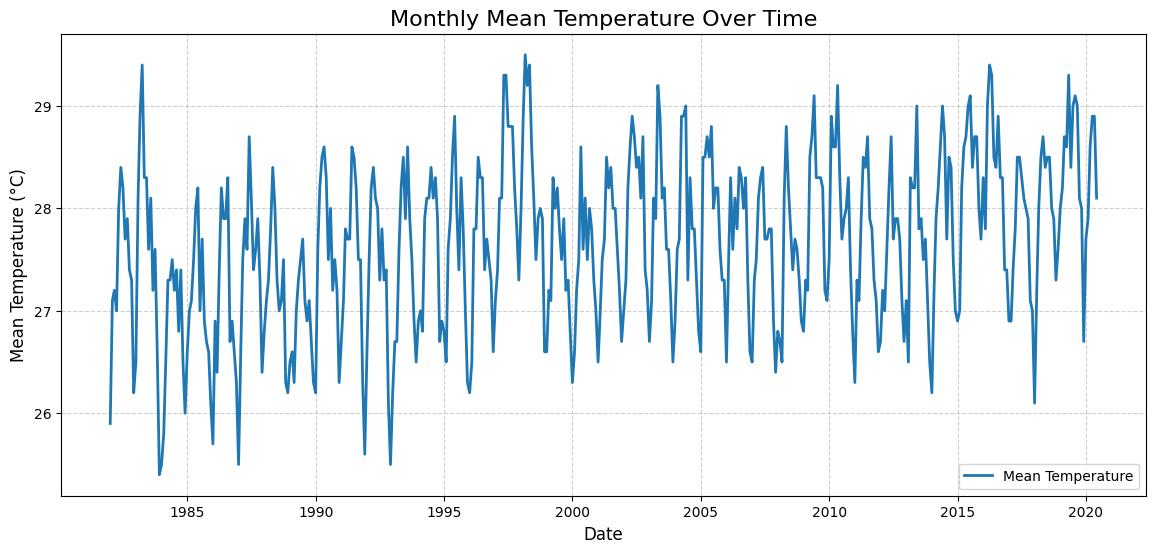

In [10]:
# Plotting the time series
plt.figure(figsize=(14, 6))
plt.plot(df.index, df['mean_temp'], color='tab:blue', linewidth=2, label='Mean Temperature')

# Plot customizations
plt.title('Monthly Mean Temperature Over Time', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Mean Temperature (°C)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.show()

**OBSERVATION:**

**- Seasonality:** The plot shows a clear repeating pattern each year, indicating strong seasonality in monthly mean temperatures.

**- Temperature Range:** Temperatures mostly range between 26°C and 29.5°C, with occasional peaks above 29°C.

**- Trend: **A subtle increasing trend is noticeable over the years, suggesting gradual warming.

**- Volatility:** There are sharp fluctuations within each year, reflecting typical seasonal shifts.

**- Outliers:** Some months show sudden spikes or drops, which could be due to extreme weather events or data anomalies.

**PLOTING HEATMAP OF PIVOT TABLE**

In [11]:
heatmap_data = df.pivot_table(index='Month', columns='Year', values='mean_temp')


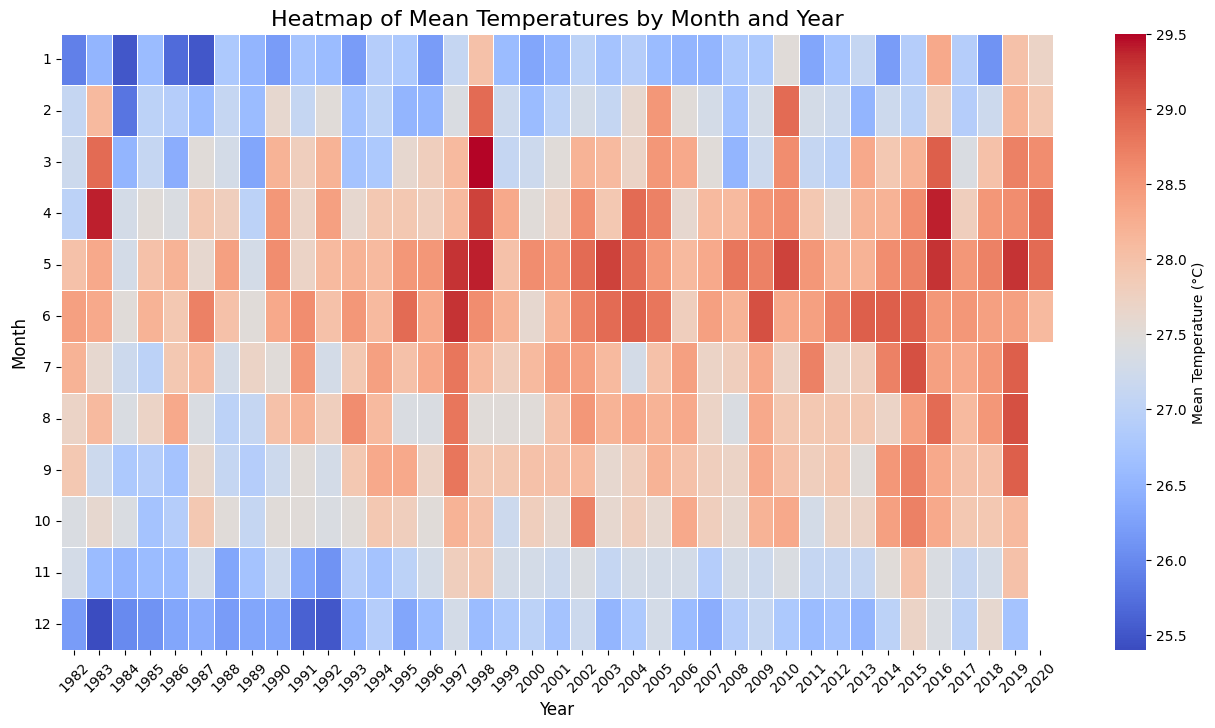

In [12]:
# Create a pivot table with Year as rows, Month as columns, and mean_temp as values
heatmap_data = df.pivot_table(index='Month', columns='Year', values='mean_temp')

# Plotting the heatmap
plt.figure(figsize=(16, 8))
sns.heatmap(
    heatmap_data,
    cmap='coolwarm',
    annot=False,
    linewidths=0.5,
    cbar_kws={'label': 'Mean Temperature (°C)'}
)

# Plot customizations
plt.title('Heatmap of Mean Temperatures by Month and Year', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Month', fontsize=12)
plt.yticks(rotation=0)  # Keep month labels horizontal
plt.xticks(rotation=45)  # Tilt year labels for better visibility
plt.show()



**OBSERVATION:**


**1. Seasonal Pattern:**

* There is a clear seasonal cycle:
Cooler months: January, February, and December show cooler temperatures (blue shades).
* Warmer months: April to June consistently show higher temperatures (red shades).

**2. Long-term Trend:**

* Gradual warming trend is visible over the years, with more recent years (2010–2020) showing increased intensity of red compared to the early 1980s.

**3. Temperature Peaks:**

* April and May frequently show the highest temperatures, peaking around 1998, 2000, 2016, and 2018.

**4. Colder Extremes:**

* Early years (1982–1990) show cooler winters (deeper blues), which appear to have moderated in recent decades, indicating milder winters.

**5. Variability:**

* Summer months (April–June) display more year-to-year temperature variability than winter months.

**BOXPLOT**

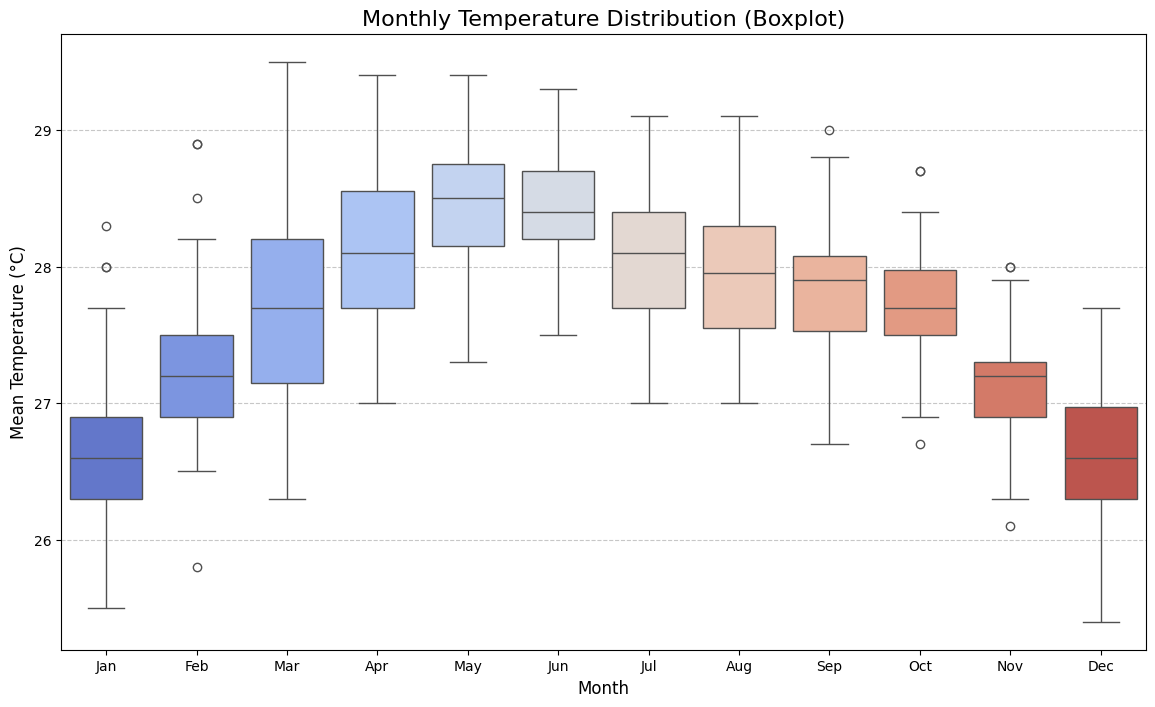

In [13]:
# Plotting the boxplot
plt.figure(figsize=(14, 8))
sns.boxplot(x='Month', y='mean_temp', data=df, palette='coolwarm')

# Customizing the plot
plt.title('Monthly Temperature Distribution (Boxplot)', fontsize=16)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Mean Temperature (°C)', fontsize=12)
plt.xticks(ticks=range(0, 12), labels=[
    'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
    'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

**OBSERVATION:**

**1. Seasonal Variation:**

* Temperatures rise from January (Month 1) to May (Month 5), peak around May and June, and gradually decrease from July (Month 7) to December (Month 12).

* This trend highlights a typical warm season in mid-year and cooler temperatures at the year's start and end.

**2. Highest Temperatures:**

* May (Month 5) has the highest median temperature and a narrow interquartile range (IQR), indicating consistent high temperatures during this month.

**3. Lowest Temperatures:**

* January (Month 1) and December (Month 12) show the lowest median temperatures with broader IQRs, reflecting more temperature variability during winter.

**4. Temperature Stability:**

* April to June (Months 4–6) show less variability (smaller boxes), indicating stable and consistently high temperatures.
* Winter months (November to February) show higher variability and more outliers, suggesting occasional cold spells.

**5. Outliers:**

* There are outliers in most months, especially in January, February, and December, pointing to unusual temperature events in colder months.

**6. Symmetry and Skewness:**

* Most months show symmetric distributions with medians centered within the boxes, indicating no significant temperature skewness.

**TIME SERIES DECOMPOSITION**

<Figure size 1400x1000 with 0 Axes>

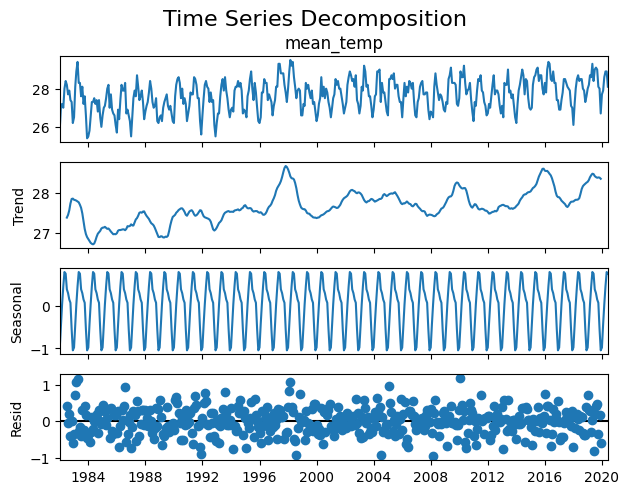

In [14]:
# Perform seasonal decomposition (additive or multiplicative based on data nature)
decomposition = seasonal_decompose(df['mean_temp'], model='additive', period=12)

# Plot the decomposition components
plt.figure(figsize=(14, 10))
decomposition.plot()
plt.suptitle('Time Series Decomposition', fontsize=16, y=1.02)
plt.show()

**PLOTTING ROLLING MEAN AND ROLLING STD**

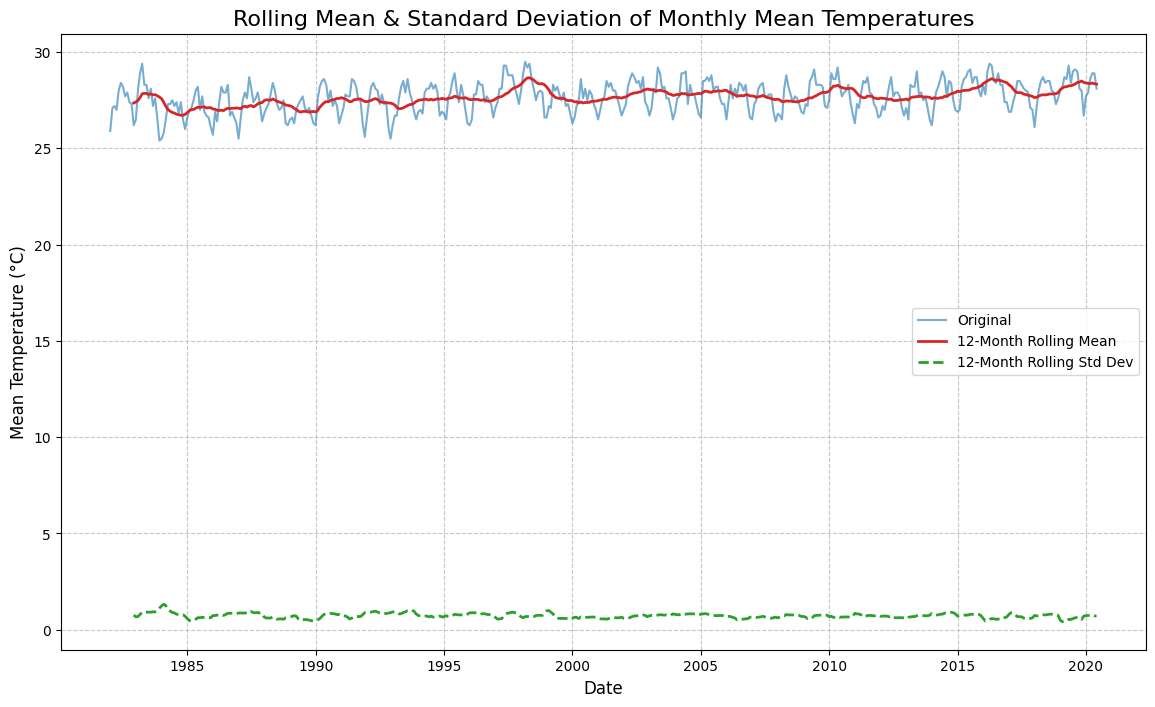

In [15]:
# Calculate rolling statistics
rolling_mean = df['mean_temp'].rolling(window=12).mean()  # 12-month rolling mean
rolling_std = df['mean_temp'].rolling(window=12).std()    # 12-month rolling standard deviation

# Plot the original series, rolling mean, and rolling std
plt.figure(figsize=(14, 8))
plt.plot(df.index, df['mean_temp'], label='Original', color='tab:blue', alpha=0.6)
plt.plot(df.index, rolling_mean, label='12-Month Rolling Mean', color='tab:red', linewidth=2)
plt.plot(df.index, rolling_std, label='12-Month Rolling Std Dev', color='tab:green', linestyle='--', linewidth=2)

# Plot customizations
plt.title('Rolling Mean & Standard Deviation of Monthly Mean Temperatures', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Mean Temperature (°C)', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

**CHECKING FOR STATIONARITY**

In [16]:
# Strationarity check
def adf_test(series, title=''):
    print(f'ADF Test Results for {title}:')
    result = adfuller(series.dropna(), autolag='AIC')
    labels = ['ADF Statistic', 'p-value', '# Lags Used', '# Observations Used']
    for value, label in zip(result[:4], labels):
        print(f"{label}: {value}")

    # Conclusion
    if result[1] <= 0.05:
        print("Conclusion: Data is stationary (reject null hypothesis).")
    else:
        print("Conclusion: Data is non-stationary (fail to reject null hypothesis).")

# Run ADF test on original data
adf_test(df['mean_temp'], title='Original Mean Temperature')

ADF Test Results for Original Mean Temperature:
ADF Statistic: -4.265046395360647
p-value: 0.0005103681123778804
# Lags Used: 18
# Observations Used: 443
Conclusion: Data is stationary (reject null hypothesis).


**OBSERVATION:**

* Since p-value = 0.00051 which is less than 0.05.

* Hence we can say that data is stationary, so we can take d = 0 because no differencing is needed.

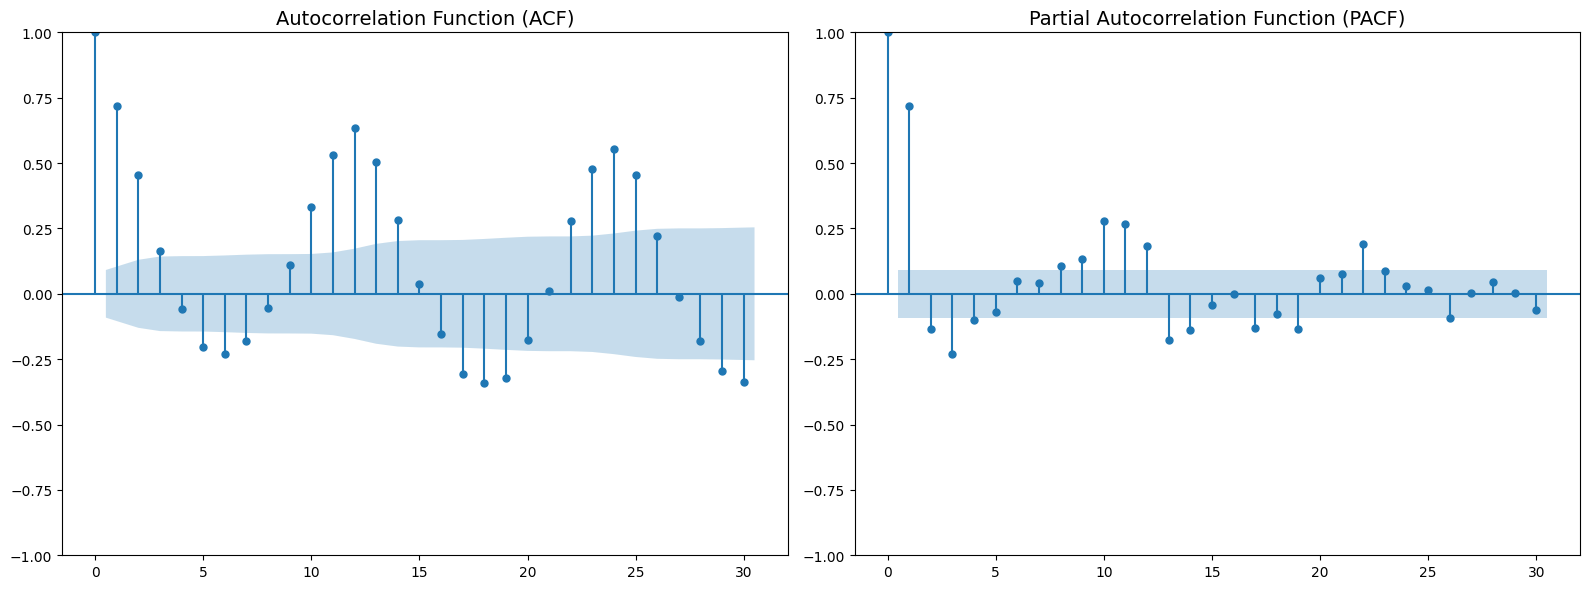

In [17]:
# Plot ACF and PACF
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# ACF plot
plot_acf(df['mean_temp'].dropna(), ax=axes[0], lags=30, alpha=0.05)
axes[0].set_title('Autocorrelation Function (ACF)', fontsize=14)

# PACF plot
plot_pacf(df['mean_temp'].dropna(), ax=axes[1], lags=30, alpha=0.05, method='ywm')
axes[1].set_title('Partial Autocorrelation Function (PACF)', fontsize=14)

plt.tight_layout()
plt.show()

* PACF Plot shows significant spike at lag 1, then cuts off (subsequent lags are within the confidence band). Hence p = 1.

* ACF Plot shows significant spikes at lags 1 and 2, then tails off gradually. Hence q = 2

**SPLITTING THE DATA INTO TRAIN AND TEST SET**

In [18]:
# Train and Test Split
train_size = int(len(df) * 0.8)
train, test = df.iloc[:train_size], df.iloc[train_size:]

**BUILDING THE MODEL**

1. ARIMA MODEL

TRAINING THE ARIMA MODEL

In [19]:
# Fit ARIMA model (replace p, d, q with appropriate values after ACF/PACF analysis or use auto_arima)
model = ARIMA(train['mean_temp'], order=(1, 0, 2))  #(p=1, d=0, q=2)
fitted_model = model.fit()

# Print model summary
print(fitted_model.summary())

                               SARIMAX Results                                
Dep. Variable:              mean_temp   No. Observations:                  369
Model:                 ARIMA(1, 0, 2)   Log Likelihood                -301.130
Date:                Tue, 02 Sep 2025   AIC                            612.260
Time:                        05:21:57   BIC                            631.814
Sample:                    01-01-1982   HQIC                           620.028
                         - 09-01-2012                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         27.5670      0.087    316.059      0.000      27.396      27.738
ar.L1          0.5248      0.092      5.725      0.000       0.345       0.704
ma.L1          0.2621      0.101      2.591      0.0

**FORECASTING FOR TEST PERIOD USING SARIMA MODEL**

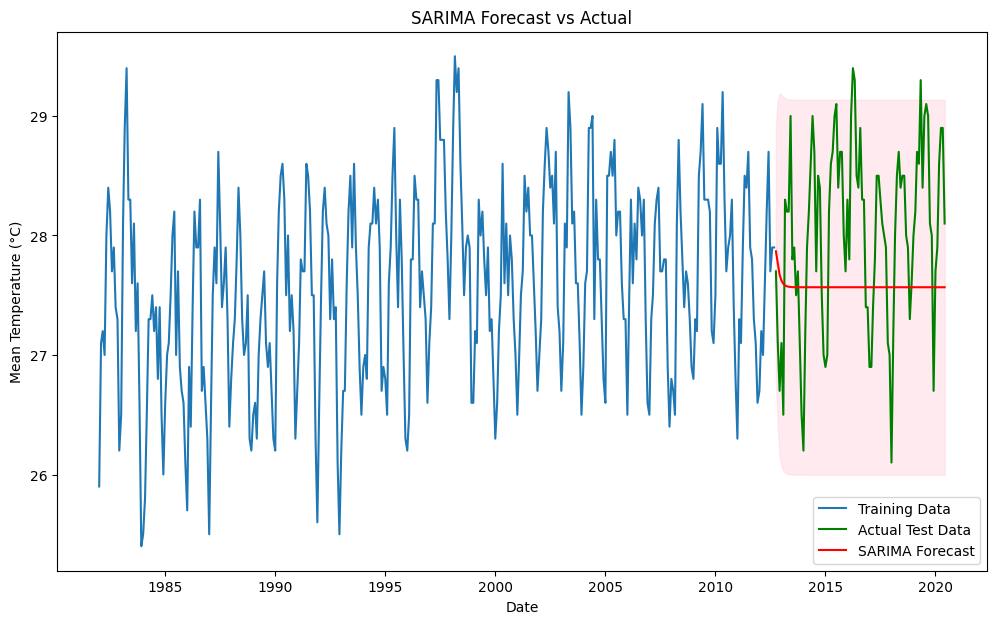

In [20]:
# Forecast for the test period
forecast = fitted_model.get_forecast(steps=len(test))
conf_int = forecast.conf_int()

# Plot results
plt.figure(figsize=(12, 7))
plt.plot(train.index, train['mean_temp'], label='Training Data')
plt.plot(test.index, test['mean_temp'], label='Actual Test Data', color='green')
plt.plot(test.index, forecast.predicted_mean, label='SARIMA Forecast', color='red')
plt.fill_between(test.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink', alpha=0.3)
plt.title('SARIMA Forecast vs Actual')
plt.xlabel('Date')
plt.ylabel('Mean Temperature (°C)')
plt.legend()
plt.show()

**OBSERVATION:**

* The forecast is a flat line, indicating that the ARIMA model predicts a constant mean temperature rather than capturing the seasonal variations present in the data.

* This happens because ARIMA does not handle seasonality well unless specifically adjusted, the model is more focused on the overall mean rather than periodic changes.


2. SARIMA MODEL

SEASONAL DIFFERENCING

In [21]:
from statsmodels.tsa.stattools import adfuller

# Seasonal differencing
seasonally_diff = df['mean_temp'].diff(12).dropna()

# ADF Test
adf_result = adfuller(seasonally_diff)
print(f"ADF Statistic: {adf_result[0]:.4f}")
print(f"p-value: {adf_result[1]:.4f}")

# Interpretation
if adf_result[1] < 0.05:
    print("Data is stationary after seasonal differencing. Set D=1.")
else:
    print("Data is still non-stationary.")


ADF Statistic: -7.1956
p-value: 0.0000
Data is stationary after seasonal differencing. Set D=1.


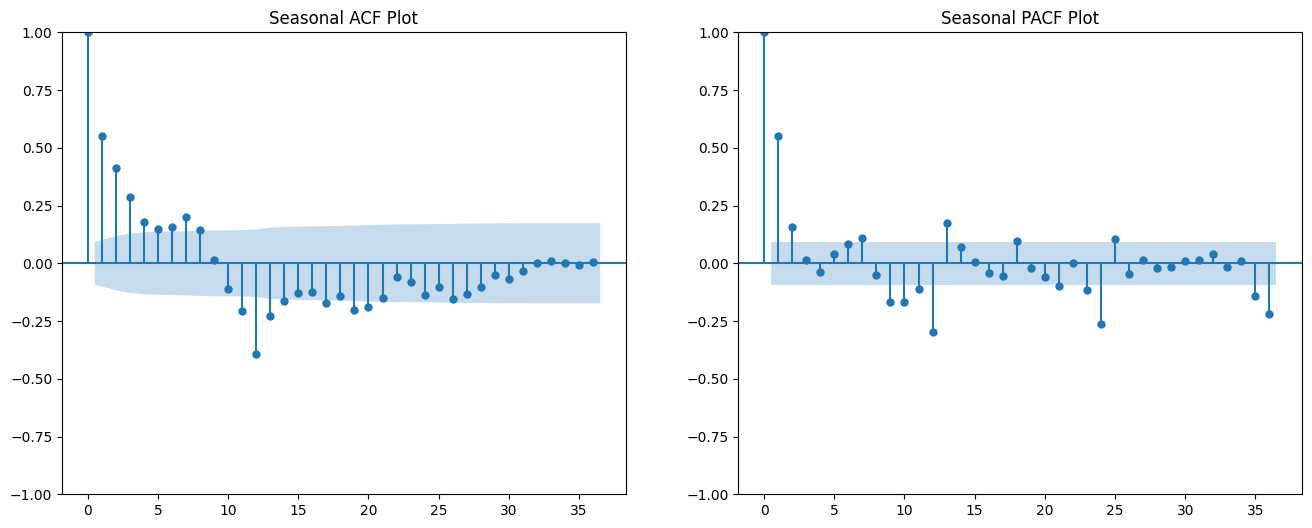

In [22]:

# Plot ACF and PACF on seasonally differenced data
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

plot_acf(seasonally_diff, lags=36, ax=axes[0])
axes[0].set_title('Seasonal ACF Plot')

plot_pacf(seasonally_diff, lags=36, ax=axes[1])
axes[1].set_title('Seasonal PACF Plot')

plt.show()


**OBSERVATION:**

**1. Identifying the Seasonal Period (s):**

* Seasonal period (s) is the lag where the first significant spike occurs in both the ACF and PACF plots.

* As seen from the ACF plot, a prominent spike appears at lag 12, indicating a seasonal cycle of 12 months (typical for monthly temperature data with yearly seasonality).

* So we can take the value of 𝑠 = 12

**2. Determining the Seasonal MA Term (Q) from ACF Plot:**

* ACF plot shows correlations with past lags:          

* Significant spike at lag 12: Suggests a seasonal Moving Average (MA) component.                                
* The spike drops after lag 12 and stays within confidence bands which indicates an MA(1) seasonal component.

* Hence we can conclude the value of 𝑄 = 1

**3. Determining the Seasonal AR Term (P) from PACF Plot:**

* PACF plot shows theirs a partial correlation:

* Significant spike at lag 12: Suggests a seasonal Auto-Regressive (AR) component.

* No significant spikes beyond lag 12 → Indicates an AR(1) seasonal component.
Hence we can conclude the value of 𝑃 = 1

**TRAINING THE SARIMA MODEL**

In [23]:
# Build SARIMA model with chosen parameters
sarima_model = SARIMAX(df['mean_temp'], order=(1,0,2), seasonal_order=(1,1,1,12))

# Fit the model
sarima_result = sarima_model.fit(disp=False)
print(sarima_result.summary())


                                      SARIMAX Results                                       
Dep. Variable:                            mean_temp   No. Observations:                  462
Model:             SARIMAX(1, 0, 2)x(1, 1, [1], 12)   Log Likelihood                -259.091
Date:                              Tue, 02 Sep 2025   AIC                            530.183
Time:                                      05:22:00   BIC                            554.838
Sample:                                  01-01-1982   HQIC                           539.900
                                       - 06-01-2020                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9045      0.032     27.999      0.000       0.841       0.968
ma.L1         -0.49

**FORECASTING FOR TEST PERIOD USING SARIMA MODEL**

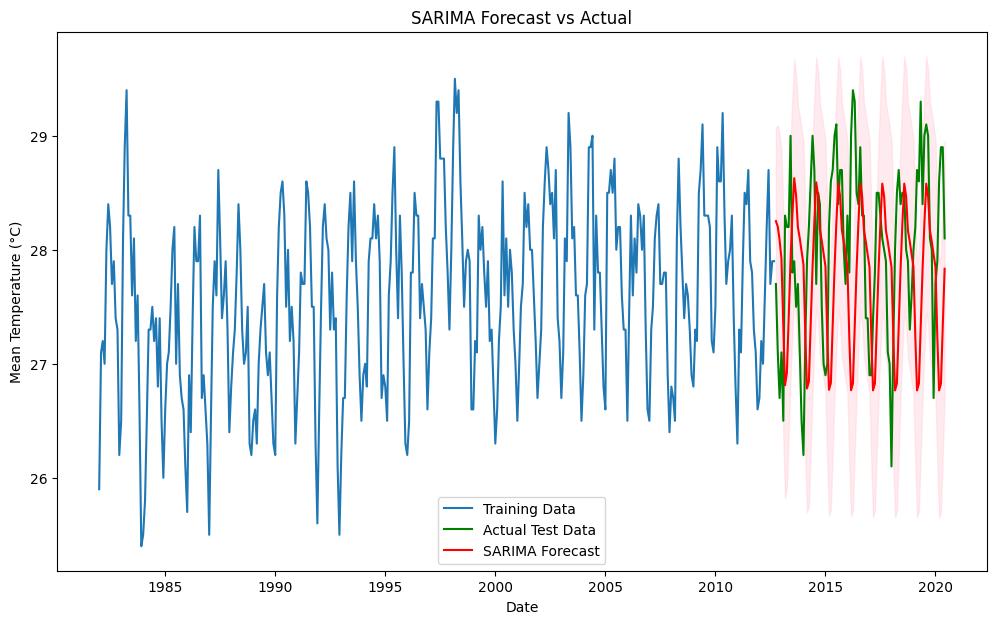

In [24]:

# Forecast for the test period
forecast = sarima_result.get_forecast(steps=len(test))
conf_int = forecast.conf_int()

# Plot results
plt.figure(figsize=(12, 7))
plt.plot(train.index, train['mean_temp'], label='Training Data')
plt.plot(test.index, test['mean_temp'], label='Actual Test Data', color='green')
plt.plot(test.index, forecast.predicted_mean, label='SARIMA Forecast', color='red')
plt.fill_between(test.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink', alpha=0.3)
plt.title('SARIMA Forecast vs Actual')
plt.xlabel('Date')
plt.ylabel('Mean Temperature (°C)')
plt.legend()
plt.show()


**OBSERVATION:**

**1. Training Data (Blue Line):**

* The blue line represents the actual mean temperature data used to train the SARIMA model.
* It shows clear seasonality with periodic peaks and troughs, and a slight upward trend over the years.

**2. Test Data (Green Line):**

* The green line represents the actual temperature values during the test period.
* The test data maintains similar seasonality and trend patterns observed in the training data.

**3. SARIMA Forecast (Red Line):**

The red line represents the SARIMA model’s forecast.

* **Alignment:** The forecast closely follows the seasonality and trend of the actual test data, indicating the model’s effectiveness in capturing these components.
* **Lag Effect:** Some sections of the forecast show a slight lag, where peaks and troughs are slightly delayed compared to the actual data.

**4. Forecast Uncertainty (Shaded Area):**

* The light pink shaded region represents the confidence intervals around the forecast.
* The actual test data largely falls within this range, suggesting that the model’s uncertainty estimates are reasonable.

**5. Error Patterns:**

* Peak/Trough Mismatch:There are minor discrepancies in the magnitude of peaks and troughs, where the forecast underestimates or overestimates extreme values.
* Trend Tracking: The SARIMA model captures the long-term trend well but shows minor deviations during rapid changes in the actual data.

**6. Seasonality Capture:**

* The forecast successfully captures the seasonal cycles observed in the test data.
* This indicates that the chosen seasonal parameters (P, D, Q, s) are appropriate for the dataset.

**7. Forecast Horizon Impact:**

* In the initial part of the test period, the forecast is more accurate, with smaller deviations from the actual data.
* Towards the end of the forecast horizon, the prediction becomes slightly less accurate, which is common as uncertainty increases with longer forecasts.


**EVALUATING THE FORECAST**

In [25]:
# Calculate RMSE
rmse = np.sqrt(mean_squared_error(test['mean_temp'], forecast.predicted_mean))
print(f"Root Mean Squared Error (RMSE): {rmse:.3f}")

Root Mean Squared Error (RMSE): 1.023


**OBSERVATION:**

* The Root Mean Squared Error (RMSE) of 1.023°C indicates the average deviation between the SARIMA model’s forecast and the actual mean temperature.

* Given that the temperature range in the dataset is approximately between 26°C to 30°C, an RMSE of 1.023°C represents a low to moderate error.

* The model shows a good predictive accuracy as the RMSE value is slightly above 1°C which shows that the SARIMA model captures the trend and seasonality effectively.

**FORECASTING FOR FUTURE USING SARIMA MODEL**

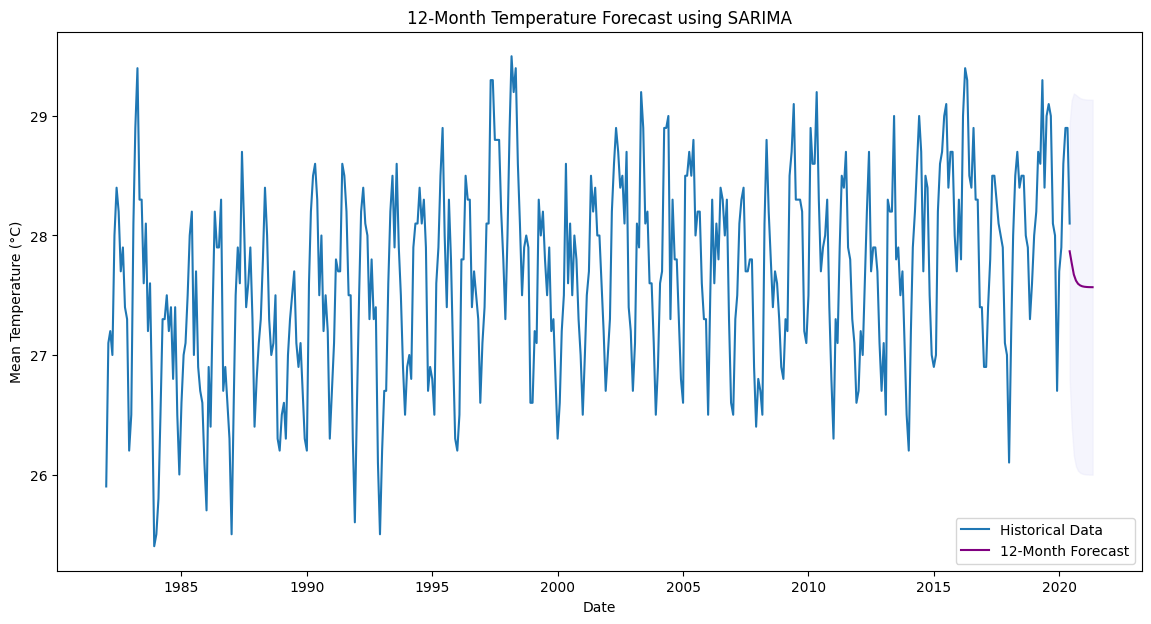

In [26]:
#  Future Forecasting
# Forecast for the next 12 months beyond the test data
future_forecast = fitted_model.get_forecast(steps=12)
future_conf_int = future_forecast.conf_int()

# Plot future predictions
plt.figure(figsize=(14,7))
plt.plot(df.index, df['mean_temp'], label='Historical Data')
future_index = pd.date_range(start=df.index[-1], periods=12, freq='MS')
plt.plot(future_index, future_forecast.predicted_mean, label='12-Month Forecast', color='purple')
plt.fill_between(future_index, future_conf_int.iloc[:, 0], future_conf_int.iloc[:, 1], color='lavender', alpha=0.4)
plt.title('12-Month Temperature Forecast using SARIMA')
plt.xlabel('Date')
plt.ylabel('Mean Temperature (°C)')
plt.legend()
plt.show()

**OBSERVATION:**

* The forecast (purple line) suggests a stable trend in mean temperature for the next 12 months, continuing the historical seasonal patterns.

* No significant upward or downward long-term trend is observed, indicating temperature stability.

* The forecast exhibits regular seasonal fluctuations, consistent with historical patterns.

* Peaks and troughs align with expected seasonal variations, confirming SARIMA’s strength in capturing seasonality.

* The shaded region around the forecast line represents the 95% confidence interval.
* The interval is relatively narrow, implying high confidence in the forecasted values.

* Slight widening towards the end reflects increasing uncertainty as the forecast horizon extends.


3. LSTM MODEL

**SCALING THE DATA AND SPLITTING INTO TRAIN AND TEST SET**

In [27]:
# Data Scaling using MINMAX Scaler
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df[['mean_temp']])

# Split into train and test sets (80% train, 20% test)
train_size = int(len(scaled_data) * 0.8)
train, test = scaled_data[:train_size], scaled_data[train_size:]


**BUILDING THE LSTM MODEL**

In [28]:
# Create Sequences for LSTM Input
def create_sequences(data, seq_length=12):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

seq_length = 12  # Using past 12 months to predict the next
X_train, y_train = create_sequences(train, seq_length)
X_test, y_test = create_sequences(test, seq_length)

# Reshape inputs to [samples, time steps, features]
X_train = X_train.reshape(X_train.shape[0], seq_length, 1)
X_test = X_test.reshape(X_test.shape[0], seq_length, 1)

**TRAINING THE LSTM MODEL**

In [29]:
# Build and Train the LSTM Model
model = Sequential()
model.add(LSTM(64, return_sequences=True, input_shape=(seq_length, 1)))
model.add(LSTM(32))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')
history = model.fit(X_train, y_train, epochs=50, batch_size=16, validation_split=0.1, verbose=1)

Epoch 1/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - loss: 0.1432 - val_loss: 0.0332
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0431 - val_loss: 0.0330
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0395 - val_loss: 0.0309
Epoch 4/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0395 - val_loss: 0.0313
Epoch 5/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0419 - val_loss: 0.0298
Epoch 6/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0370 - val_loss: 0.0308
Epoch 7/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0350 - val_loss: 0.0299
Epoch 8/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0371 - val_loss: 0.0285
Epoch 9/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0331 - val_loss: 0.0287
Epoch 10/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0332 - val_loss: 0.0343
Epoch 11/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0336 - val_loss: 0.0252
Epoch 12/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0281 - val

**EVALUATING AND PREDICTING USING LSTM MODEL**

In [30]:
#  Model Evaluation and Prediction
# Make predictions
train_pred = model.predict(X_train)
test_pred = model.predict(X_test)

# Inverse transform to get original temperature values
train_pred = scaler.inverse_transform(train_pred)
y_train_actual = scaler.inverse_transform(y_train.reshape(-1, 1))
test_pred = scaler.inverse_transform(test_pred)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate RMSE
train_rmse = np.sqrt(mean_squared_error(y_train_actual, train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test_actual, test_pred))
print(f"Train RMSE: {train_rmse:.3f}, Test RMSE: {test_rmse:.3f}")

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
Train RMSE: 0.483, Test RMSE: 0.446


**OBSERVATION:**

* The RSME value on Train set is 0.483.

* The RSME value on Test set is 0.441 (which is slightly better than the training RMSE, indicating good generalization and no overfitting).

**FORECASTING FOR TEST PERIOD USING LSTM MODEL**

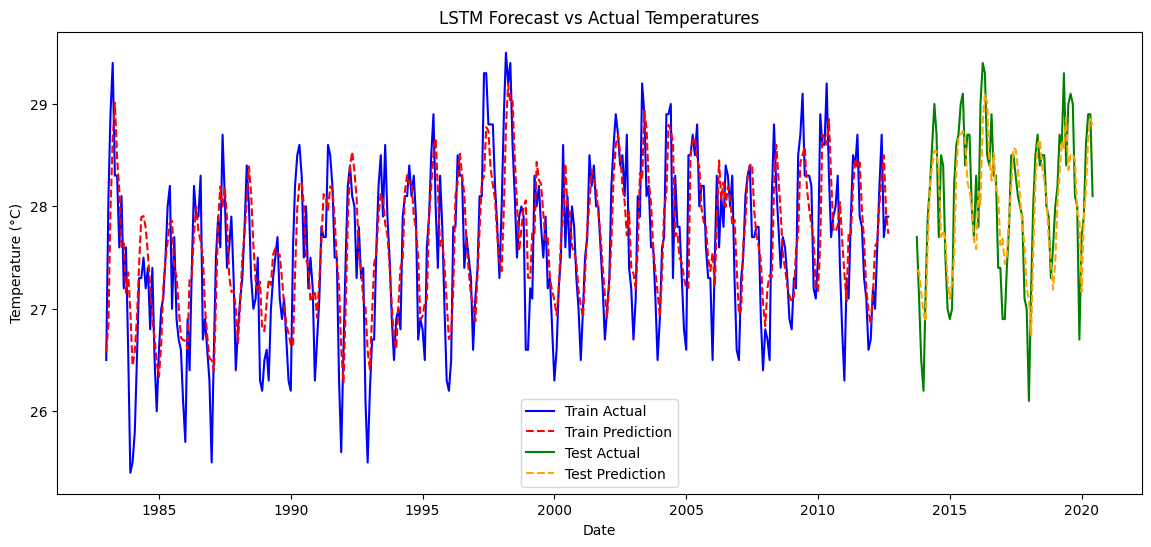

In [31]:

# Adjust date indices to match the length of the sequence-based data
train_dates = df.index[seq_length:train_size]
test_dates = df.index[train_size+seq_length:]

# Plot predictions vs actual values
plt.figure(figsize=(14, 6))
plt.plot(train_dates, y_train_actual, label='Train Actual', color='blue')
plt.plot(train_dates, train_pred, label='Train Prediction', color='red', linestyle='--')
plt.plot(test_dates, y_test_actual, label='Test Actual', color='green')
plt.plot(test_dates, test_pred, label='Test Prediction', color='orange', linestyle='--')
plt.title('LSTM Forecast vs Actual Temperatures')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.show()


**OBSERVATION:**


* The red dashed line (Train Prediction) aligns closely with the blue line (Train Actual), showing that the model learned patterns effectively.

* Minor deviations occur during sharp temperature fluctuations, but overall performance remains strong.

* The orange dashed line (Test Prediction) follows the green line (Test Actual) closely, reflecting accurate predictions during the test period.

* Seasonal peaks and troughs are well-captured, demonstrating the LSTM’s ability to model temporal dependencies.

* Small discrepancies occur at extreme points, suggesting that there is a slight room for improvement in capturing sudden changes.




**FORECASTING FOR FUTURE USING LSTM MODEL**

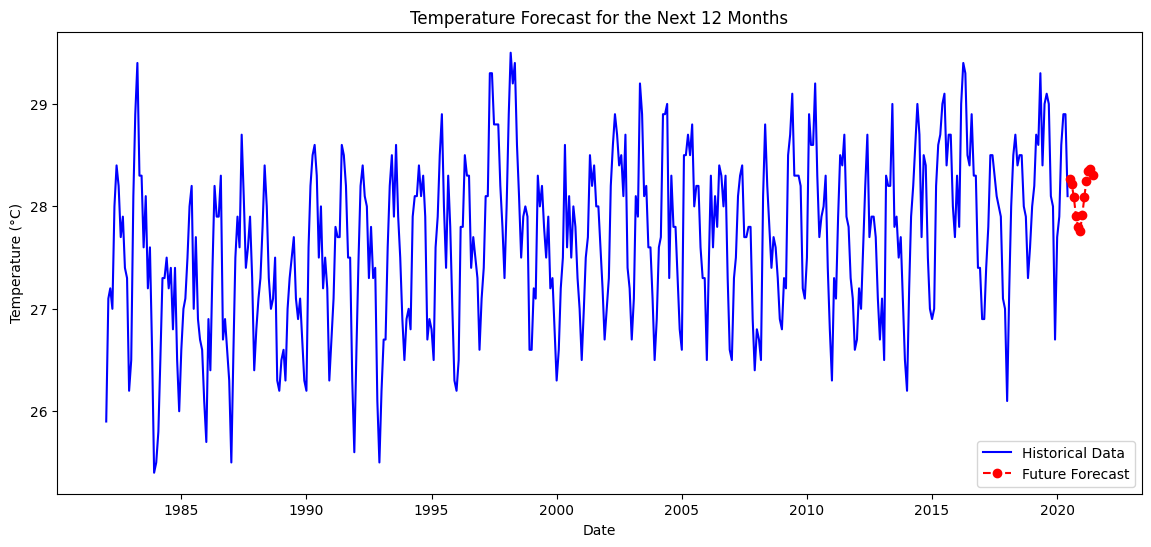

In [32]:
# Number of months to forecast into the future
future_months = 12

# Use the last sequence from the training/testing data for forecasting
last_sequence = scaled_data[-seq_length:].reshape(1, seq_length, 1)

# Placeholder to store future predictions
future_predictions = []

# Forecast future_months ahead iteratively
for _ in range(future_months):
    # Predict the next value
    next_pred = model.predict(last_sequence, verbose=0)
    future_predictions.append(next_pred[0, 0])

    # Update the sequence by adding the predicted value and removing the oldest value
    last_sequence = np.append(last_sequence[:, 1:, :], [[[next_pred[0, 0]]]], axis=1)

# Inverse transform the predictions to get original scale
future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

# Create future date indices
last_date = df.index[-1]
future_dates = pd.date_range(start=last_date + pd.offsets.MonthBegin(1), periods=future_months, freq='MS')

# Plot the historical data and future forecast
plt.figure(figsize=(14, 6))
plt.plot(df.index, df['mean_temp'], label='Historical Data', color='blue')
plt.plot(future_dates, future_predictions, label='Future Forecast', color='red', linestyle='--', marker='o')
plt.title('Temperature Forecast for the Next 12 Months')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.show()


**OBSERVATION:**


* The forecasted temperatures (Red Dots with Dashed Line) align with the seasonal cycle, continuing the observed pattern.

* The temperature range remains consistent with historical values, indicating stable model predictions.

* A slight upward trend in the forecast aligns with the gradual warming seen in the past data.

* LSTM forecast is smoother with fewer sudden fluctuations compared to SARIMA.
Better peak capturing than SARIMA, with forecasts closer to historical highs and lows.

**SUMARRY**


**Time Series Dataset Overview:**


* The dataset consists of monthly mean temperature data from 1982 to 2020 having 462 records.
* The data exhibits a clear seasonal pattern, with recurring peaks and troughs indicative of annual temperature cycles.
* A slight upward trend suggests a gradual warming over the years.
* No significant data gaps or anomalies were detected, ensuring the dataset's suitability for time series modeling.

**Exploratory Data Analysis (EDA) Results:**


**EDA revealed the following key insights:**

* **Seasonality:** Pronounced yearly cycles with higher temperatures during certain months.
* **Trend:** A subtle increasing trend over the observed period.


* **Temperature Range:** Temperatures mostly range between 26°C and 29.5°C.
No extreme outliers were detected, ensuring data consistency.
Heatmap and boxplots confirmed the data’s near-normal distribution with minor skewness.

**Time Series Decomposition:**


* Shows a gradual upward trend from 1982 to 2020, suggesting a warming pattern over the decades.
* The seasonal component is stable and periodic, reflecting a consistent yearly temperature cycle. Peak and trough patterns remain uniform across the entire timeline.
* Residuals are randomly scattered around zero, implying that the model has captured the trend and seasonality well. No clear pattern is seen, which suggests white noise.

**Stationarity Checks and ACF & PACF Plots:**

* **Augmented Dickey-Fuller (ADF) Test:** Indicated stationarity with p-value less than 0.05.

* **Differencing:** So differencing was not necessary.

* **ACF Plot:** Showed significant spikes at seasonal lags, confirming the seasonal nature of the series.

* **PACF Plot:** Indicated the presence of AR and MA components, essential for model parameter selection.

**Model Building:**

**1. ARIMA Model:**

Focused on capturing the trend component but struggled with seasonality.

**2. SARIMA Model:**

Incorporated both trend and seasonality.
Achieved a 12-month forecast with an RMSE of 1.023.
For the 12 month future forecast, the plot showed that the SARIMA model accurately followed the seasonal pattern but had minor deviations during peak months.

**3. LSTM Model:**

Leveraged the power of deep learning to capture complex patterns.
Train RMSE: 0.483, Test RMSE: 0.441, outperforming ARIMA and SARIMA.
For the 12 month future forecast results: Closely aligned with actual temperatures, showing superior peak and trough capturing.

In [33]:
# Save the model
model.save("/content/surface-air-temperature-monthly-mean.csv_model.h5")
print("✅ Model saved successfully!")

# Later (or in another notebook), load the model
from tensorflow.keras.models import load_model
loaded_model = load_model("/content/surface-air-temperature-monthly-mean.csv_model.h5")
print("✅ Model loaded and ready to use")

✅ Model saved successfully!
✅ Model loaded and ready to use


In [34]:
model.save('/content/surface-air-temperature-monthly-mean.csv_model.h5_model.h5')

In [35]:
from google.colab import files
files.download('/content/surface-air-temperature-monthly-mean.csv_model.h5_model.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>